<div style="width: 38.5%;">
    <p><strong>City College of San Francisco</strong><p>
    <hr>
    <p>MATH 108 - Foundations of Data Science</p>
</div>

# Lecture 31: Least Squares

Associated Textbook Sections: [15.3, 15.4](https://inferentialthinking.com/chapters/15/3/Method_of_Least_Squares.html)

<h2>Set Up the Notebook<h2>

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in this course.

def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

def slope(t, x, y):
    return correlation(t, x, y) * np.std(t.column(y)) / np.std(t.column(x)) 

def intercept(t, x, y):
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(y)) 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-31:-Least-Squares" data-toc-modified-id="Lecture-31:-Least-Squares-1">Lecture 31: Least Squares</a></span><ul class="toc-item"><li><span><a href="#Set-Up-the-Notebook" data-toc-modified-id="Set-Up-the-Notebook-1.1">Set Up the Notebook</a></span></li><li><span><a href="#" data-toc-modified-id="-1.2"></a></span></li><li><span><a href="#Least-Squares" data-toc-modified-id="Least-Squares-1.3">Least Squares</a></span><ul class="toc-item"><li><span><a href="#Demonstration" data-toc-modified-id="Demonstration-1.3.1">Demonstration</a></span></li><li><span><a href="#Error-in-Estimation" data-toc-modified-id="Error-in-Estimation-1.3.2">Error in Estimation</a></span></li><li><span><a href="#Demo:-Regression-line-vs-other-lines" data-toc-modified-id="Demo:-Regression-line-vs-other-lines-1.3.3">Demo: Regression line vs other lines</a></span></li><li><span><a href="#Least-Squares-Line" data-toc-modified-id="Least-Squares-Line-1.3.4">Least Squares Line</a></span></li><li><span><a href="#Demo:-Root-Mean-Square-Error" data-toc-modified-id="Demo:-Root-Mean-Square-Error-1.3.5">Demo: Root Mean Square Error</a></span></li><li><span><a href="#Numerical-Optimization" data-toc-modified-id="Numerical-Optimization-1.3.6">Numerical Optimization</a></span></li><li><span><a href="#Demo:-Numerical-Optimization" data-toc-modified-id="Demo:-Numerical-Optimization-1.3.7">Demo: Numerical Optimization</a></span></li><li><span><a href="#Demo:-Minimizing-RMSE" data-toc-modified-id="Demo:-Minimizing-RMSE-1.3.8">Demo: Minimizing RMSE</a></span></li></ul></li></ul></li></ul></div>

## Least Squares

### Demonstration

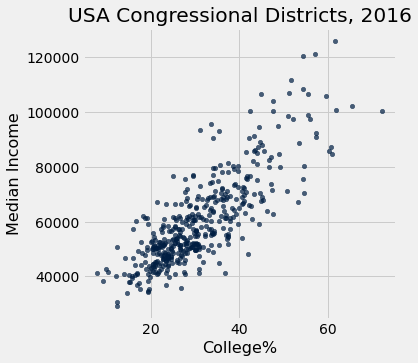

In [2]:
demographics = Table().read_table('district_demographics2016.csv')
demographics.scatter('College%', 'Median Income')
plots.title('USA Congressional Districts, 2016')
plots.show()

Based only on the above graph, which must be true?
1. Going to college causes people to get higher incomes.
2. For any district, having more college-educated people live there causes median incomes to rise.
3. For any district, having a higher median income causes more college-educated people to move there.

### Error in Estimation

* `error = actual value - estimate`
* Typically, some errors are positive and some negative
* To measure the rough size of the errors
    * square the errors to eliminate cancellation
    * take the mean of the squared errors
    * take the square root to fix the units
    * root mean square error (rmse)

### Demo: Regression line vs other lines

Use the following functions with the 2016 demographics data to explore the relationship between Median Income and College completion within the US voting districts.

In [3]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [4]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [5]:
demographics = Table.read_table('district_demographics2016.csv')
demographics

State,District,Median Income,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,30.3
Alabama,"Congressional District 6 (115th Congress), Alabama",61413,36.7
Alabama,"Congressional District 7 (115th Congress), Alabama",34664,19.4
Alaska,"Congressional District (at Large) (115th Congress), Alaska",76440,29.6
Arizona,"Congressional District 1 (115th Congress), Arizona",50537,24.5
Arizona,"Congressional District 2 (115th Congress), Arizona",49072,34


In [6]:
demographics = demographics.drop(
    'State', 'District')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


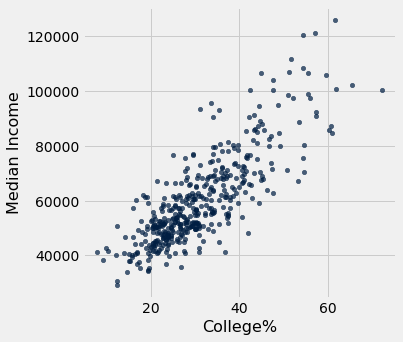

In [7]:
demographics.scatter('College%', 'Median Income')

In [8]:
correlation(demographics, 'College%', 'Median Income')

0.8184648517141335

Determine the slope and intercept for the linear regression line to predict median income values from college% values.

In [9]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, -76251181.89630301)

In [10]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

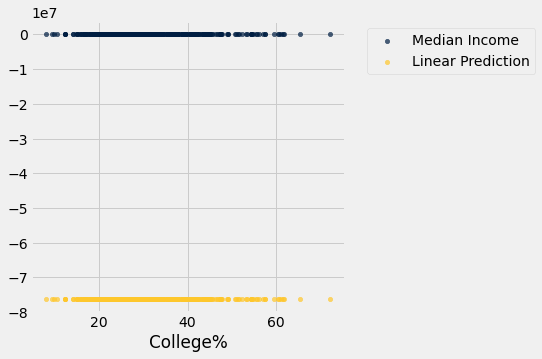

In [11]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

Analyze the errors formed when applying the predictions on the provided `College%` data values.

In [12]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [13]:
demographics.with_column('Error', errors)

Median Income,College%,Linear Prediction,Error
47083,24,-7.62207e+07,7.62678e+07
42035,21.8,-7.62235e+07,7.62655e+07
46544,22.8,-7.62222e+07,7.62688e+07
41110,17,-7.62296e+07,7.62707e+07
51690,30.3,-7.62127e+07,7.62644e+07
61413,36.7,-7.62045e+07,7.6266e+07
34664,19.4,-7.62265e+07,7.62612e+07
76440,29.6,-7.62136e+07,7.629e+07
50537,24.5,-7.622e+07,7.62706e+07
49072,34,-7.6208e+07,7.62571e+07


In [14]:
np.mean(errors)

76271984.4740697

In [15]:
np.mean(errors ** 2) ** 0.5

76271985.05312958

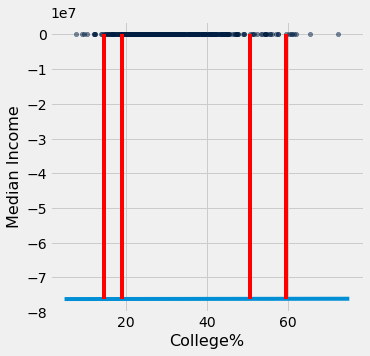

In [16]:
demographics_errors(regression_slope, regression_intercept)

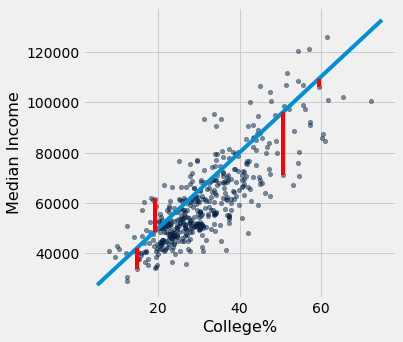

In [17]:
# takes any slope, any intercept

demographics_errors(1500, 20000)

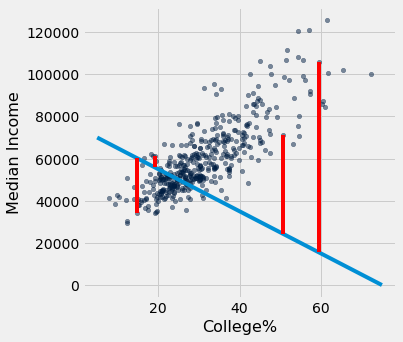

In [18]:
demographics_errors(-1000, 75000)

### Least Squares Line

* Minimizes the root mean squared error (rmse) among all lines
* Equivalently, minimizes the mean squared error (mse) among all lines
* Common Names:
    * "Best fit" line
    * Least squares line
    * Regression line


### Demo: Root Mean Square Error

Explore the root mean square error through the demographics relationship.

In [19]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

Root mean squared error: 30247.88


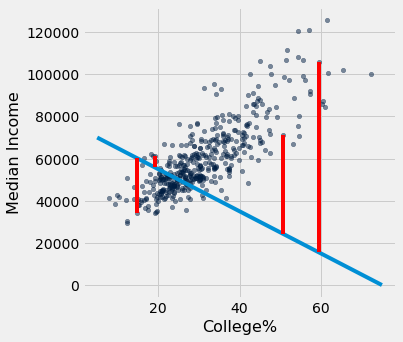

In [20]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 11559.09


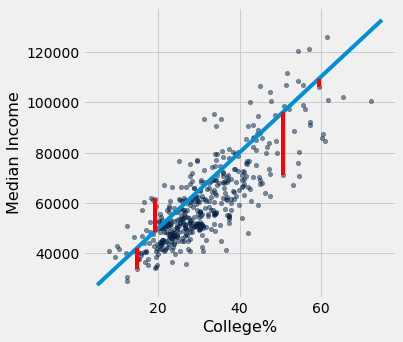

In [21]:
show_demographics_rmse(1500, 20000)

Root mean squared error: 76271985.05


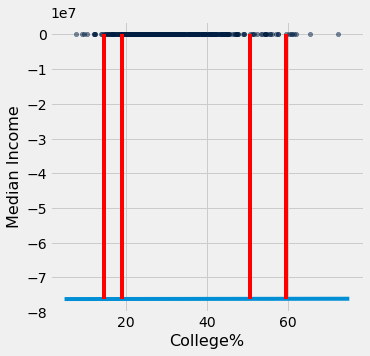

In [22]:
show_demographics_rmse(regression_slope, regression_intercept)

### Numerical Optimization

* Numerical minimization is approximate but effective
* Lots of machine learning uses numerical minimization
* If the function `mse(a, b)` returns the mse of estimation using the line `estimate = ax + b`, then `minimize(mse)` returns array `[slope, intercept]`
* the values are the slope and the intercept of the line that minimizes the mse among all possible lines.

### Demo: Numerical Optimization

Explore the concept of numerical optimization.

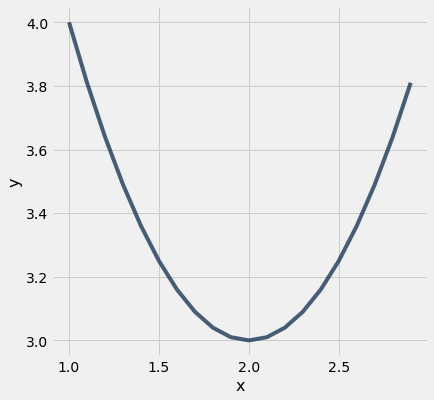

In [23]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [24]:
def f(x):
    return ((x-2)**2) + 3

In [25]:
minimize(f)

1.9999999946252267

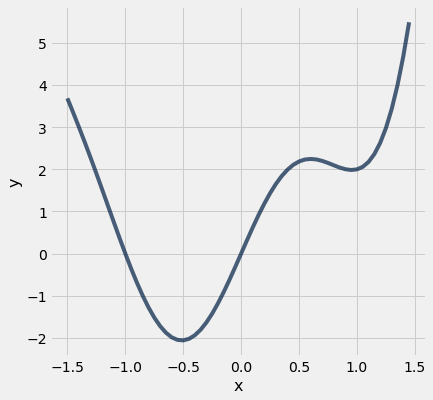

In [26]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [27]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [28]:
minimize(complicated_function)

-0.5126437620940081

### Demo: Minimizing RMSE

Show how minimizing on the demographics rmse produces the same slope and intercept values found above. 

In [29]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [30]:
demographics_rmse(1500, 20000)

11559.086490075999

In [31]:
demographics_rmse(-1000, 75000)

30247.883767944502

In [32]:
minimize(demographics_rmse)

array([ 1270.70168805, 20802.57933807])

In [33]:
make_array(regression_slope, regression_intercept)

array([ 1.27070169e+03, -7.62511819e+07])

<footer>
    <hr>
    <p>Adopted from UC Berkeley DATA 8 course materials.</p>
    <p>This content is offered under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">CC Attribution Non-Commercial Share Alike</a> license.</p>
</footer>